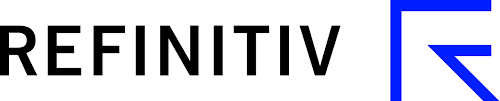

# 2022:Refinitiv Article series. All rights reserved

## Finding Option RICs

[Overview](#Overview)<br>
[Install and import packages](#Install-and-import-packages)<br>
[Section 1: Define supplementary functions](#Section-1:-Define-supplementary-functions)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [1.1 Function to get exchange codes where the option is traded](#1.1-Function-to-get-exchange-codes-where-the-option-is-traded)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [1.2 Function to check if found RIC is valid (if price data exists)](#1.2-Function-to-check-if-found-RIC-is-valid-(if-price-data-exists))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [1.3 Function to get option Expiration month code](#1.3-Function-to-get-option-Expiration-month-code)<br>
[Section 2: Define functions to get option RICs for each exchange](#Section-2:-Define-functions-to-get-option-RICs-for-each-exchange)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [2.1 Function for OPRA](2.1-Function-for-OPRA)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [2.2 Function for the Stock Exchange of Hong Kong](#2.2-Function-for-the-Stock-Exchange-of-Hong-Kong)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [2.3 Function for the Osaka Stock Exchange](#2.3-Function-for-the-Osaka-Stock-Exchange)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [2.4 Function for OPRA](#2.4-Function-for-OPRA)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [2.5 Function for the Intercontinental Exchange](#2.5-Function-for-the-Intercontinental-Exchange)<br>
[Section 3: Universal function for all above exchanges](#Section-3:-Universal-function-for-all-above-exchanges)

### Overview

The current notebook includes functions to constructs option RICs on equities and indices. Section 1 defines supplementarty functions which are further called by the main RIC construction functions. In section 2, I define separate functions per supported stock exchange. Section 3, defines a universal function which takes isin, maturity, strike and option type as an input, finds all exchanges where the options on the given asset are traded, constructs RICs for them, validates and returns the constructed RICs along with the prices.

The current version covers the following exchanges:
* US OPRA - refer to RULES7, RULES2, RULES3, RULES4 in Workspace, and Guideline for strikes above 10000 in [MyRefinitiv](https://my.refinitiv.com/content/mytr/en/datanotification/DN099473.html).
* EUREX - refer to RULES2, RULES3, RULES4 in Workspace, and general option RIC structure in [MyRefinitiv](https://my.refinitiv.com/content/mytr/en/faqs/2016/09/000195632.html). 
* Osaka Exchange - refer to RULES2, RULES3, RULES4 in Workspace, and RIC structure for Osaka exchange in [MyRefinitiv](https://my.refinitiv.com/content/mytr/en/faqs/2014/10/000189842.html).
* Stock Exchange of Hong Kong - refer to RULES2, RULES3, RULES4 in Workspace, and RIC structure for HK exchange in [MyRefinitiv](https://my.refinitiv.com/content/mytr/en/faqs/2021/04/000198505.html).
* Hong Kong Future Exchange - refer to RULES2, RULES3, RULES4 in Workspace, and RIC structure for HK exchange in [MyRefinitiv](https://my.refinitiv.com/content/mytr/en/faqs/2021/04/000198505.html).
* Intercontinental Exchange (ICE) - refer to RULES2, RULES3, RULES4 in Workspace, and general option RIC structure in [MyRefinitiv](https://my.refinitiv.com/content/mytr/en/faqs/2016/09/000195632.html). 

Syntax for the expired options is universal accross exchanges and can be found [here](https://my.refinitiv.com/content/mytr/en/faqs/2018/09/000178972.html).

## Install and import packages

To start, we first install and import the necessary packages. We use the Refinitiv Data Libraries to retrieve the data. The code are built using Python 3.9. Other prerequisite packages are installed below:

In [ ]:
!pip install refinitiv.data

In [1]:
import refinitiv.data as rd
import pandas as pd
from refinitiv.data.errors import RDError
from datetime import timedelta
from datetime import datetime

rd.open_session()

<refinitiv.data.session.Definition object at 0x7f47252395e0 {name='codebook'}>

### Section 1: Defining helper functions

Functions in this section are helpers and are further called from the functions in Section 2 and Section 3.

#### 1.1 Function to get exchange codes where the option is traded

This function allows to get the list of exchange codes where an option on the given asset is traded. The function takes asset RIC as an input and returns the list of exchanges. Then function is Section 3 constructs RICs for all supported exchanges in that list. The core of the function is the **RD Search** function.

In [10]:
def get_exchange_code(asset):
    
    response = rd.discovery.search(
        query = asset,
        filter = "SearchAllCategory eq 'Options' and Periodicity eq 'Monthly' ",
        select = 'ExchangeCode',
        group_by = "ExchangeCode",
    )
    exchanges = response.drop_duplicates()["ExchangeCode"].to_list()
    exchange_codes = []
    for exchange in exchanges:
        exchange_codes.append(exchange)
        
    return exchange_codes

In [11]:
get_exchange_code('.FTSE')

['IEU', 'EUX']

#### 1.2 Function to get option Expiration month code

This function takes expiration date and option type as an input and returns expiration month code for the option which is further used to construct RICs

In [12]:
def get_exp_month(maturity, opt_type, strike = None, opra=False):
    
    maturity = pd.to_datetime(maturity)
    # define option expiration identifiers
    ident = {'1': {'exp': 'A','C': 'A', 'P': 'M'}, 
           '2': {'exp': 'B', 'C': 'B', 'P': 'N'}, 
           '3': {'exp': 'C', 'C': 'C', 'P': 'O'}, 
           '4': {'exp': 'D', 'C': 'D', 'P': 'P'},
           '5': {'exp': 'E', 'C': 'E', 'P': 'Q'},
           '6': {'exp': 'F', 'C': 'F', 'P': 'R'},
           '7': {'exp': 'G', 'C': 'G', 'P': 'S'}, 
           '8': {'exp': 'H', 'C': 'H', 'P': 'T'}, 
           '9': {'exp': 'I', 'C': 'I', 'P': 'U'}, 
           '10': {'exp': 'J', 'C': 'J', 'P': 'V'},
           '11': {'exp': 'K', 'C': 'K', 'P': 'W'}, 
           '12': {'exp': 'L', 'C': 'L', 'P': 'X'}}
    
    # get expiration month code for a month
    if opt_type.upper() == 'C':
        exp_month = ident[str(maturity.month)]['C']
        
    elif opt_type.upper() == 'P':
        exp_month = ident[str(maturity.month)]['P']
    
    if opra and strike > 999.999:
        exp_month = exp_month.lower()
            
    return ident, exp_month

In [13]:
ident, exp_month = get_exp_month('2022-06-03', 'P', strike = 100, opra = True)
exp_month

'R'

#### 1.3 Function to check for expiry

This function checks if the option is expired or not and adds the expiration numenclature if it is.

In [14]:
def check_expiry(ric, maturity, ident):
    maturity = pd.to_datetime(maturity)
    if maturity < datetime.now():
        ric = ric + '^' + ident[str(maturity.month)]['exp'] + str(maturity.year)[-2:]
    return ric

In [15]:
check_expiry('AAPLA212216000.U', '2022-01-21', ident)

'AAPLA212216000.U^A22'

#### 1.4 Function to request prices

This function allows validation of the constructed option RICs by requesting prices. If prices are returned, we can confirm that the RIC(s) is (are) valid, otherwise, we can't confirm the validation.

In [21]:
def request_prices(ric):
    prices = []
    try:    
        prices = rd.get_history(ric, fields = ['BID','ASK','TRDPRC_1','SETTLE'])
    except RDError as err:
        print(f'Constructed ric {ric} -  {err}')
    return prices

In [23]:
request_prices('AAPLA212216000.U^A22')

AAPLA212216000.U^A22,BID,ASK,TRDPRC_1,SETTLE
Date,,,,
2021-12-23,17.15,17.45,17.36,<NA>
2021-12-27,20.9,21.0,21.0,<NA>
2021-12-28,19.95,20.3,19.95,<NA>
2021-12-29,19.85,20.05,20.05,<NA>
2021-12-30,18.5,19.0,18.9,<NA>
2021-12-31,17.95,18.75,18.2,<NA>
2022-01-03,22.0,22.25,22.15,<NA>
2022-01-04,19.85,20.2,20.07,<NA>
2022-01-05,15.35,15.8,15.57,<NA>


### Section 2: Define functions to get option RICs for each exchange

In this section I define functions for option RIC construction for separate exchanges. Those functions take asset RIC, maturity, strike and opt type as an input and return validated rics along with the prices.

#### 2.1 Function for OPRA

Below function returns option RICs for OPRA exchange.

In [24]:
def get_ric_opra(asset, maturity, strike, opt_type):
    maturity = pd.to_datetime(maturity)
    
    # trim underlying asset's RIC to get the required part for option RIC
    if asset[0] == '.': # check if the asset is an index or an equity
        asset_name = asset[1:] # get the asset name - we remove "." symbol for index options
    else:
        asset_name = asset.split('.')[0] # we need only the first part of the RICs for equities
        
    ident, exp_month = get_exp_month(maturity, opt_type, strike = strike, opra=True)

    # get strike prrice
    if type(strike) == float:
        int_part = int(strike)
        dec_part = str(str(strike).split('.')[1])
    else:
        int_part = int(strike)
        dec_part = '00'
    if len(dec_part) == 1:
        dec_part = dec_part + '0'

    if int(strike) < 10:
        strike_ric = '00' + str(int_part) + dec_part
    elif int_part >= 10 and int_part < 100:
        strike_ric = '0' + str(int_part) + dec_part
    elif int_part >= 100 and int_part < 1000:
        strike_ric = str(int_part) + dec_part
    elif int_part >= 1000 and int_part < 10000:
        strike_ric = str(int_part) + '0'
    elif int_part >= 10000 and int_part < 20000:
        strike_ric = 'A' + str(int_part)[-4:]
    elif int_part >= 20000 and int_part < 30000:
        strike_ric = 'B' + str(int_part)[-4:]      
    elif int_part >= 30000 and int_part < 40000:
        strike_ric = 'C' + str(int_part)[-4:]
    elif int_part >= 40000 and int_part < 50000:
        strike_ric = 'D' + str(int_part)[-4:]
        
    # build ric
    ric = asset_name + exp_month + str(maturity.day) + str(maturity.year)[-2:] + strike_ric + '.U'
    ric = check_expiry(ric, maturity, ident)
    
    prices = request_prices(ric)
    
    # return valid ric(s)
    if len(prices) == 0:
        print('RIC with specified parameters is not found')

    return ric, prices

In [25]:
ric, prices = get_ric_opra('AAPL.O', '2022-01-21', 180, 'C')

In [26]:
ric

'AAPLA212218000.U^A22'

In [27]:
prices.head()

AAPLA212218000.U^A22,BID,ASK,TRDPRC_1,SETTLE
Date,,,,
2021-12-23,3.45,3.6,3.53,<NA>
2021-12-27,5.15,5.25,5.2,<NA>
2021-12-28,4.55,4.7,4.55,<NA>
2021-12-29,4.25,4.35,4.25,<NA>
2021-12-30,3.45,3.6,3.5,<NA>


#### 2.2 Function for the Stock Exchange of Hong Kong

Below function returns option RICs for Hong Kong exchange.

In [28]:
def get_ric_hk(asset, maturity, strike, opt_type):
    maturity = pd.to_datetime(maturity)
    
    # get asset name and strike price for the asset
    if asset[0] == '.': 
        asset_name = asset[1:] 
        strike_ric = str(int(strike))
    else:
        asset_name = asset.split('.')[0]
        strike_ric = str(int(strike * 100))
     
    # get expiration month codes
    ident, exp_month = get_exp_month(maturity, opt_type)

    # get rics for options on indexes. Return if valid add to the possible_rics list if no price is found
    if asset[0] == '.':
        ric = asset_name + strike_ric + exp_month + str(maturity.year)[-1:] + '.HF'
        ric = check_expiry(ric, maturity, ident)
        prices = request_prices(ric)
        
        if len(prices) == 0:
            print('RIC with specified parameters is not found')
        else:
            return ric, prices
    else:
        # get rics for options on equities. Return if valid add to the possible_rics list if no price is found
        # there could be several generations of options depending on the number of price adjustments due to a corporate event
        # here we use 4 adjustment opportunities.
        for i in range(4): 
            ric = asset_name + strike_ric + str(i)+ exp_month + str(maturity.year)[-1:] + '.HK'
            ric = check_expiry(ric, maturity, ident)
            prices = request_prices(ric)
            if len(prices) == 0:
                print('RIC with specified parameters is not found')
            else:
                return ric, prices
    return ric, prices

In [29]:
ric, prices = get_ric_hk('.HSI', '2022-03-30', 18400, 'C')

In [30]:
ric

'HSI18400C2.HF^C22'

In [31]:
prices.head()

HSI18400C2.HF^C22,BID,ASK,TRDPRC_1,SETTLE
Date,,,,
2022-03-03,<NA>,<NA>,<NA>,3993
2022-03-04,<NA>,<NA>,<NA>,3475
2022-03-07,<NA>,<NA>,<NA>,2622
2022-03-08,<NA>,<NA>,<NA>,2573
2022-03-09,<NA>,<NA>,<NA>,2246


#### 2.3 Function for the Osaka Stock Exchange

Below function returns option RICs for Osaka exchange.

In [32]:
def get_ric_ose(asset, maturity, strike, opt_type):
    
    maturity = pd.to_datetime(maturity)
    strike_ric = str(strike)[:3] 
    ident, exp_month = get_exp_month(maturity, opt_type)
    
    j_nets = ['', 'L', 'R']
    generations = ['Y', 'Z', 'A', 'B', 'C']
    
    if asset[0] == '.':
        index_dict = {'N225':'JNI', 'TOPX':'JTI'}
        # Option Root codes for indexes are different from the RIC, so we rename where necessery
        asset_name = index_dict[asset.split('.')[1]]
        
        # we consider also J-NET (Off-Auction(with "L")) and High  frequency (with 'R') option structures 
        for jnet in j_nets:
            ric = asset_name + jnet + strike_ric + exp_month + str(maturity.year)[-1:] + '.OS'
            ric = check_expiry(ric, maturity, ident)
            prices = request_prices(ric)
            if len(prices) == 0:
                print('RIC with specified parameters is not found')
            else:
                return ric, prices
    else:
        asset_name = asset.split('.')[0]
         # these are generation codes similar to one from HK 
        for jnet in j_nets:
            for gen in generations:
                ric = asset_name + jnet + gen + strike_ric + exp_month + str(maturity.year)[-1:] + '.OS'
                ric = check_expiry(ric, maturity, ident)
                prices = request_prices(ric)
                if len(prices) == 0:
                    print('RIC with specified parameters is not found')
                else:
                    return ric, prices
    return ric, prices

In [33]:
ric, prices = get_ric_ose('7974.T', '2022-03-30', 50000, 'P')

In [34]:
ric

'7974Y500O2.OS^C22'

In [35]:
prices.head()

7974Y500O2.OS^C22,BID,ASK,TRDPRC_1,SETTLE
Date,,,,
2022-02-08,<NA>,<NA>,<NA>,602.5
2022-02-09,<NA>,<NA>,<NA>,520.5
2022-02-10,<NA>,<NA>,<NA>,549.0
2022-02-14,<NA>,<NA>,<NA>,629.5
2022-02-15,<NA>,<NA>,<NA>,612.5


#### 2.4 Function for the EUREX

Below function returns option RICs for EUREX exchange.

In [36]:
def get_ric_eurex(asset, maturity, strike, opt_type):
    maturity = pd.to_datetime(maturity)

    if asset[0] == '.': 
        index_dict = {'FTSE':'OTUK', 'SSMI':'OSMI', 'GDAXI':'GDAX', 'ATX':'FATXA', 'STOXX50E':'STXE'}
        asset_name = index_dict[asset.split('.')[1]]
    else:
        asset_name = asset.split('.')[0]
        
    ident, exp_month = get_exp_month(maturity, opt_type)
        
    if type(strike) == float:
        int_part = int(strike)
        dec_part = str(str(strike).split('.')[1])[0]
    else:
        int_part = int(strike)
        dec_part = '0'      
    if len(str(int(strike))) == 1:
        strike_ric = '0' + str(int_part) + dec_part
    else:
        strike_ric = str(int_part) + dec_part
    
    generations = ['', 'a', 'b', 'c', 'd']
    for gen in generations:
        ric = asset_name + strike_ric  + gen + exp_month + str(maturity.year)[-1:] + '.EX'
        ric = check_expiry(ric, maturity, ident)
        prices = request_prices(ric)
        if len(prices) == 0:
            print('RIC with specified parameters is not found')
        else:
            return ric, prices
    return ric, prices

In [37]:
ric, prices = get_ric_eurex('.STOXX50E', '2022-03-30', 4200, 'P')

In [38]:
ric

'STXE42000O2.EX^C22'

In [39]:
prices.head()

STXE42000O2.EX^C22,BID,ASK,TRDPRC_1,SETTLE
Date,,,,
2022-02-21,246.2,256.5,250.0,250.4
2022-02-22,241.7,253.0,227.5,246.3
2022-02-23,245.1,259.9,246.0,253.3
2022-02-24,70.0,391.5,375.0,382.9
2022-02-25,247.1,263.3,271.0,252.8


#### 2.5 Function for the Intercontinental Exchange

Below function returns option RICs for Intercontinental Exchange exchange.

In [40]:
def get_ric_ieu(asset, maturity, strike, opt_type):
    maturity = pd.to_datetime(maturity)
    
    if asset[0] == '.':
        index_dict = {'FTSE':'LFE'}
        asset_name = index_dict[asset.split('.')[1]]     
    else:
        asset_name = asset.split('.')[0] 
        
    ident, exp_month = get_exp_month(maturity, opt_type)

    if len(str(int(strike))) == 2:
        strike_ric = '0' + str(int(strike))
    else:
        strike_ric = str(int(strike))
        
    if type(strike) == float and len(str(int(strike))) == 1:
        int_part = int(strike)
        dec_part = str(str(strike).split('.')[1])[0]        
        strike_ric = '0' + str(int_part) + dec_part
    
    generations = ['', 'a', 'b', 'c', 'd']
    for gen in generations:
        ric = asset_name + strike_ric  + gen + exp_month + str(maturity.year)[-1:] + '.L'
        ric = check_expiry(ric, maturity, ident)
        prices = request_prices(ric)
        if len(prices) == 0:
            print('RIC with specified parameters is not found')
        else:
            return ric, prices
    return  ric, prices

In [41]:
ric, prices = get_ric_ieu('.FTSE', '2022-06-30', 7000, 'C')

In [42]:
ric

'LFE7000F2.L^F22'

In [43]:
prices.head()

LFE7000F2.L^F22,BID,ASK,TRDPRC_1,SETTLE
Date,,,,
2022-05-23,<NA>,<NA>,<NA>,530.5
2022-05-24,518,537.5,<NA>,510.0
2022-05-25,<NA>,<NA>,<NA>,551.5
2022-05-26,<NA>,<NA>,<NA>,584.5
2022-05-27,<NA>,<NA>,<NA>,596.5


### Section 3: Universal function for all above exchanges

In this section I built a universal function which takes ric, maturity, strike and option type as an input, finds all exchanges where the options on given asset are traded, constructs RICs for them, validates and returns the constructed RICs along with the prices.

In [45]:
def get_option_ric(asset, maturity, strike, opt_type):
    
    # define covered exchanges along with functions to get RICs from
    exchanges = {'OPQ': get_ric_opra,
           'IEU': get_ric_ieu,
           'EUX': get_ric_eurex,
           'HKG': get_ric_hk,
           'HFE': get_ric_hk,
           'OSA': get_ric_ose}
    
    # get exchanges codes where the option on the given asset is traded
    exchnage_codes = get_exchange_code(asset)
    # get the list of (from all available and covered exchanges) valid rics and their prices
    options_data = {}
    for exch in exchnage_codes:
        if exch in exchanges.keys():
            ric, prices = exchanges[exch](asset, maturity, strike, opt_type)
            if len(prices) != 0:
                options_data[ric] = prices
                print(f'Option RIC for {exch} exchange is successfully constructed')     
        else:
            print(f'The {exch} exchange is not supported yet')
    return options_data

In [46]:
# options_data = get_option_ric('ABBN.S', '2022-03-30', 34, 'C')
# options_data = get_option_ric('ALVG.DE', '2022-03-18', 220, 'C')
# options_data = get_option_ric('BBVA.MC', '2022-03-18', 4.7, 'C')
# options_data = get_option_ric('AIRP.PA', '2022-03-18', 150, 'C')
# options_data = get_option_ric('BARC.L', '2022-03-18', 210, 'P')
# options_data = get_option_ric('AZN.L', '2022-03-18', 9000, 'P')
# options_data = get_option_ric('VOD.L', '2022-03-18', 100, 'P')
# options_data = get_option_ric('ALSO.PA', '2022-06-18', 36, 'P')
# options_data = get_option_ric('ENI.MI', '2022-06-16', 13, 'C')
# options_data = get_option_ric('ASML.AS', '2022-02-18', 640, 'P')
# options_data = get_option_ric('.HSI', '2022-03-30', 18400, 'C')
# options_data = get_option_ric('1093.HK', '2022-03-30', 10, 'C')
# options_data = get_option_ric('0700.HK', '2022-04-28', 480, 'C')
# options_data = get_option_ric('.TOPX', '2022-06-10', 1900, 'C')
# options_data = get_option_ric('6501.T', '2022-06-10', 6500, 'C')
# options_data = get_option_ric('.STOXX50E', '2022-03-18', 4200, 'C')
# options_data = get_option_ric('.N225', '2022-01-17', 25875, 'C')
options_data = get_option_ric('.SPX', '2022-02-18', 5000, 'C')

Option RIC for OPQ exchange is successfully constructed


In [48]:
options_data

{'SPXb182250000.U^B22': SPXb182250000.U^B22   BID   ASK  TRDPRC_1  SETTLE
 Date                                             
 2022-01-21           0.25   0.6       0.5    <NA>
 2022-01-24            0.5   0.7      0.65    <NA>
 2022-01-25            0.4   0.6      0.53    <NA>
 2022-01-26            0.4   0.8      0.75    <NA>
 2022-01-27            0.3   0.4       0.4    <NA>
 2022-01-28           0.45  0.65       0.6    <NA>
 2022-01-31            0.2   0.3      0.25    <NA>
 2022-02-01            0.2   0.3      0.23    <NA>
 2022-02-02           0.05  0.25      0.25    <NA>
 2022-02-03           0.05  0.15      0.15    <NA>
 2022-02-04           0.05   0.1       0.1    <NA>
 2022-02-07           <NA>   0.1      0.05    <NA>
 2022-02-08           <NA>   0.1      0.08    <NA>
 2022-02-09           <NA>  0.15      0.08    <NA>
 2022-02-10           <NA>  0.05      0.03    <NA>
 2022-02-11           <NA>  0.15      <NA>    <NA>
 2022-02-14           <NA>  0.05      0.05    <NA>
 2022-02

### Conclusion

Current article preseneted functions to find valid RICs for options on stock and indices traded in several exchanges. Additionally, I presented a universal function which finds the exchanges where an option on a given asset is traded, constructs RICs for them, validates and returns the constructed RICs along with the price.

The current version of this article is limited for certain exchanges, includig OPRA, EUREX, ICE, Hong Kong and Osaka, and for options on certain asset types, including indices and stocks. Please let me know which other exchanges and/or options on other asset categories you want me to build functions for. You can contact me directly via h.aramyan@refinitiv.com or raise your questions/suggestion via Q&A portal of Developer community.